# Data Exploration

**Description**: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

In this competition, you will predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc. The data comes from renthop.com, an apartment listing website. These apartments are located in New York City.

The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site. 

In [100]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#color = sns.color_palette()
#sns.palplot(sns.color_palette('colorblind'))
sns.set_palette('dark')

%matplotlib inline

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
train_df = pd.read_json('train.json').reset_index(drop=True)
test_df = pd.read_json('test.json').reset_index(drop=True)

In [3]:
train_df.shape, test_df.shape

((49352, 15), (74659, 14))

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 5.6+ MB


In [5]:
train_df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street


In [6]:
pd.options.display.float_format = '{:,.0f}'.format
train_df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,"49,352","49,352","49,352","49,352","49,352","49,352"
mean,1,2,41,"7,024,055",-74,"3,830"
std,1,1,1,"126,275",1,"22,067"
min,0,0,0,"6,811,957",-118,43
25%,1,1,41,"6,915,888",-74,"2,500"
50%,1,1,41,"7,021,070",-74,"3,150"
75%,1,2,41,"7,128,733",-74,"4,100"
max,10,8,45,"7,753,784",0,"4,490,000"


In [7]:
train_df[(train_df.price==43) | (train_df.price==4490000)]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
19558,1,2,cd25bbea2af848ebe9821da820b725da,2016-06-24 05:02:11,,Hudson Street,"[Doorman, Elevator, Cats Allowed, Dogs Allowed...",low,41,7208764,-74,d1737922fe92ccb0dc37ba85589e6415,[],4490000,421 Hudson Street
28626,1,0,64f8e51f01a36ab0cd55fe9de2381306,2016-05-24 05:24:56,<p><a website_redacted,Madison,"[Doorman, Elevator, High Speed Internet]",low,41,7060255,-74,29ebd2f6553fbe12706a006a97349dd6,[],43,60 Madison


In [8]:
print 'Min: ', train_df.created.min()
print 'Max: ', train_df.created.max()

Min:  2016-04-01 22:12:41
Max:  2016-06-29 21:41:47


In [9]:
train_df['created'] = pd.to_datetime(train_df.created)

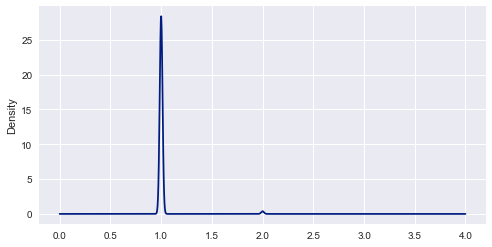

In [10]:
train_df.created.value_counts().sort_index().plot(kind='density', figsize=(8,4))

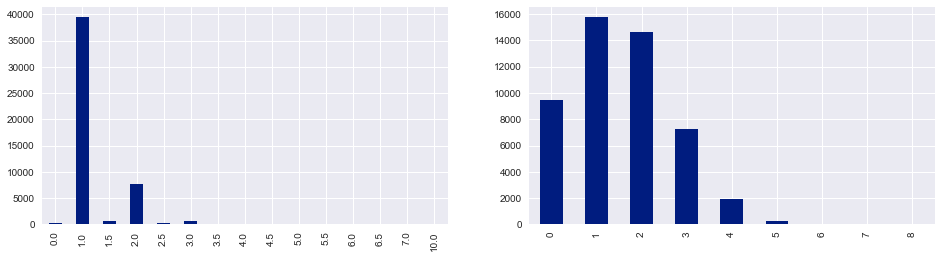

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

train_df.bathrooms.value_counts().sort_index().plot(kind='bar', ax=axes[0])
train_df.bedrooms.value_counts().sort_index().plot(kind='bar', ax=axes[1])

### Remove outliners from numeric variables

In [12]:
train_df.isnull().sum(axis = 0) # no missing data

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
interest_level     0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

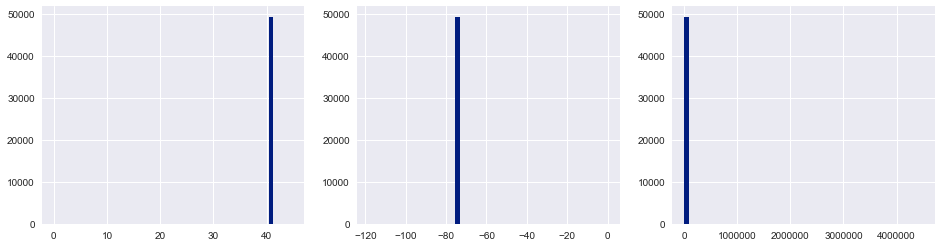

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

train_df.latitude.hist(bins = 50, ax=axes[0])
train_df.longitude.hist(bins = 50, ax=axes[1])
train_df.price.hist(bins = 50, ax=axes[2])

40.6404 40.862047


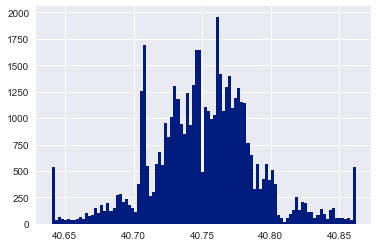

In [14]:
lat_min, lat_max = np.percentile(train_df.latitude, [1, 99]).tolist()
print lat_min, lat_max

train_df.latitude = np.where(train_df.latitude < lat_min, lat_min, train_df.latitude)
train_df.latitude = np.where(train_df.latitude > lat_max, lat_max, train_df.latitude)

train_df.latitude.hist(bins = 100)

-74.0162 -73.852651


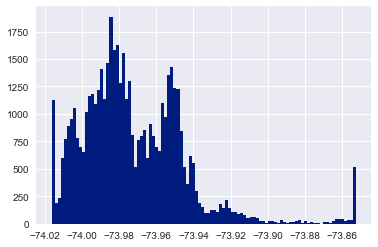

In [15]:
lon_min, lon_max = np.percentile(train_df.longitude, [1, 99]).tolist()
print lon_min, lon_max

train_df.longitude = np.where(train_df.longitude < lon_min, lon_min, train_df.longitude)
train_df.longitude = np.where(train_df.longitude > lon_max, lon_max, train_df.longitude)

train_df.longitude.hist(bins = 100)

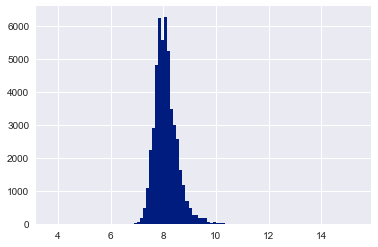

In [16]:
train_df['price_log'] = np.log(train_df.price)

train_df.price_log.hist(bins = 100)

1475.0 13000.0


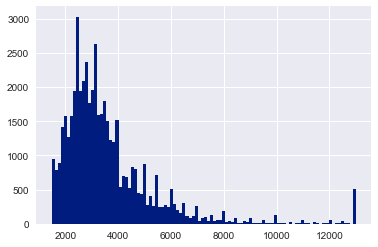

In [17]:
price_min, price_max = np.percentile(train_df.price, [1, 99]).tolist()
print price_min, price_max

train_df.price = np.where(train_df.price < price_min, price_min, train_df.price)
train_df.price = np.where(train_df.price > price_max, price_max, train_df.price)

train_df.price.hist(bins = 100)

### Target variable and its correlation within the others

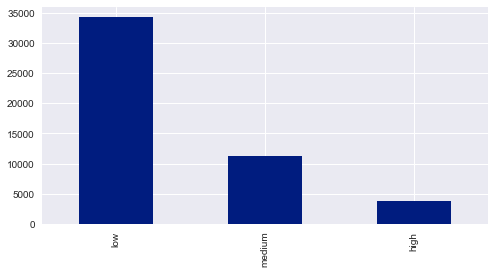

In [18]:
train_df.interest_level.value_counts().plot(kind='bar', figsize=(8,4))

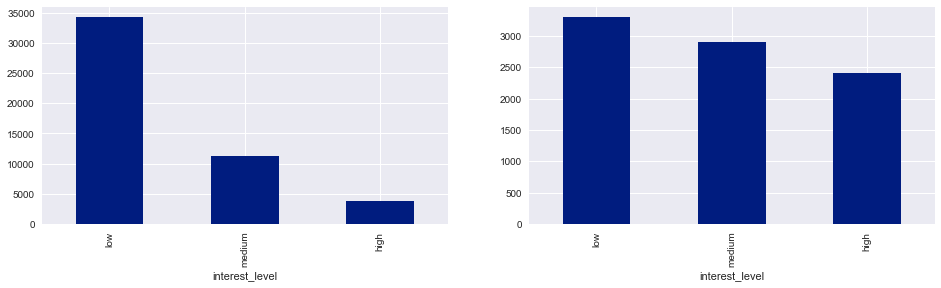

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

train_df.groupby('interest_level').price.count().reindex([u'low', u'medium', u'high']).plot(kind='bar', ax=axes[0])
train_df.groupby('interest_level').price.median().reindex([u'low', u'medium', u'high']).plot(kind='bar', ax=axes[1])

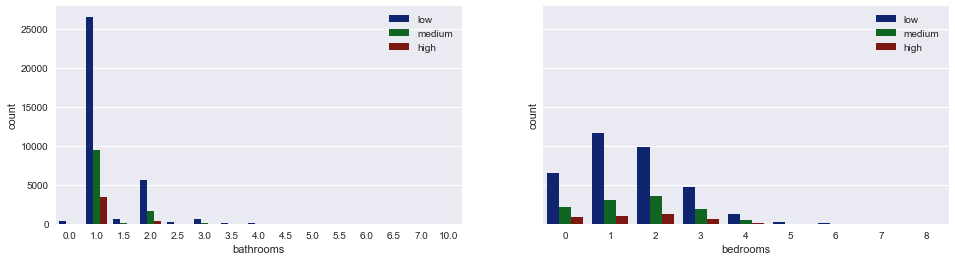

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.countplot(x='bathrooms', hue='interest_level', data=train_df, hue_order=[u'low', u'medium', u'high'], ax=ax1).legend(loc=1).figure.set_size_inches(16,4)
sns.countplot(x='bedrooms', hue='interest_level', data=train_df, hue_order=[u'low', u'medium', u'high'], ax=ax2).legend(loc=1).figure.set_size_inches(16,4)

In [21]:
train_df.building_id.value_counts()[:10]

0                                   8286
96274288c84ddd7d5c5d8e425ee75027     275
11e1dec9d14b1a9e528386a2504b3afc     215
80a120d6bc3aba97f40fee8c2204524b     213
bb8658a3e432fb62a440615333376345     212
f68bf347f99df026f4faad43cc604048     191
c94301249b8c09429d329864d58e5b82     167
ce6d18bf3238e668b2bf23f4110b7b67     165
57ef86c28a8ae482dc3a3c3af28e8e48     159
128d4af0683efc5e1eded8dc8044d5e3     153
Name: building_id, dtype: int64

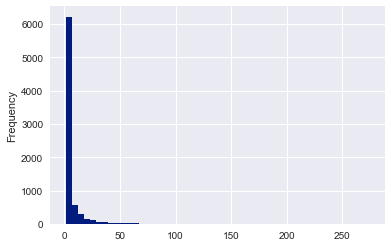

In [22]:
bldg_id_counts = train_df.building_id.value_counts()
train_df['listings_in_bldg'] = train_df.building_id.map(lambda b: bldg_id_counts[b] if b != '0' else 1)

train_df.building_id[train_df.building_id != '0'].value_counts().plot(kind='hist', bins=50)

In [23]:
train_df.manager_id.value_counts()[:10]

e6472c7237327dd3903b3d6f6a94515a    2533
6e5c10246156ae5bdcd9b487ca99d96a     711
8f5a9c893f6d602f4953fcc0b8e6e9b4     410
62b685cc0d876c3a1a51d63a0d6a8082     402
cb87dadbca78fad02b388dc9e8f25a5b     373
9df32cb8dda19d3222d66e69e258616b     330
b7de4cb395920136663132057fa89d84     320
2aa9bfa5f67ed9997ea341dee8a3a271     316
ad3d8ddc52c7e0859b5c6c7f7949c3bd     305
c9c33695ee2a2f818e9f1d8f7d1c4b39     299
Name: manager_id, dtype: int64

In [24]:
sf = train_df.manager_id.value_counts()
managers_df = pd.DataFrame({'manager_id':sf.index, 'cnt':sf.values})
managers_df.where(managers_df.cnt == 1).sum()

cnt   969
dtype: float64

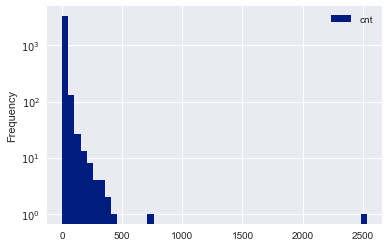

In [25]:
managers_df.plot(kind='hist', bins=50, log=True)

In [26]:
train_df['num_photos'] = train_df.photos.apply(len)
train_df['num_features'] = train_df.features.apply(len)
train_df['description_size'] = train_df.description.apply(lambda x: len(x.split(" ")))

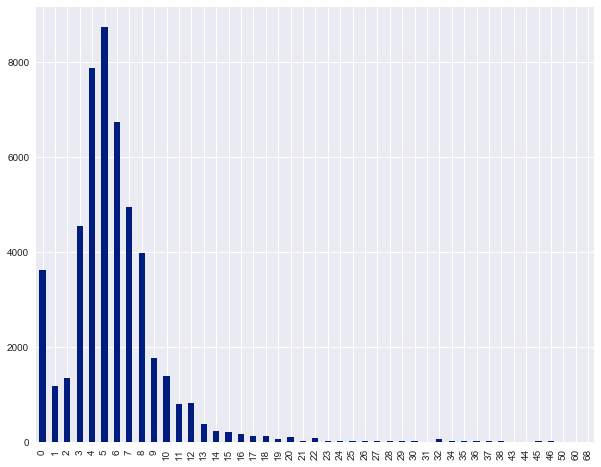

In [27]:
train_df.num_photos.value_counts().sort_index().plot(kind='bar', figsize=(10,8))

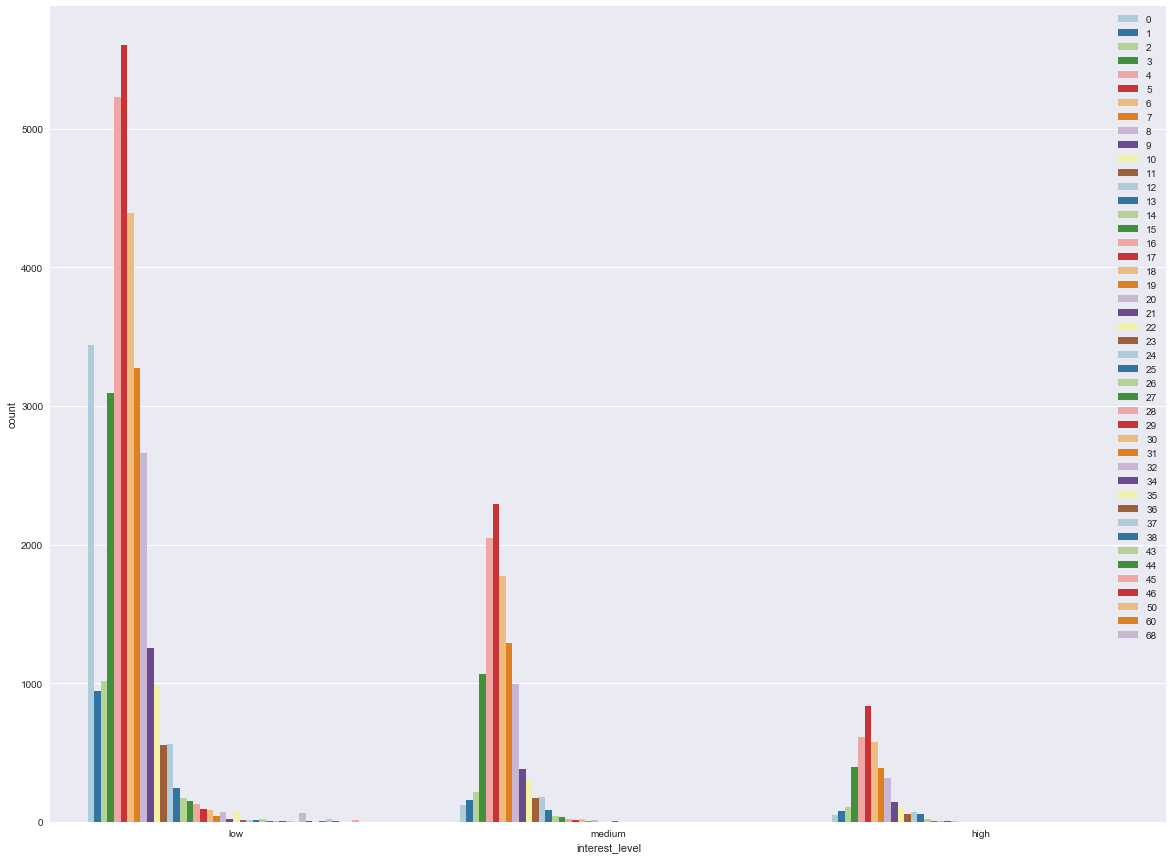

In [28]:
sns.countplot(x='interest_level', hue='num_photos', data=train_df, order=[u'low', u'medium', u'high'], palette='Paired').legend(loc=1).figure.set_size_inches(20,15)

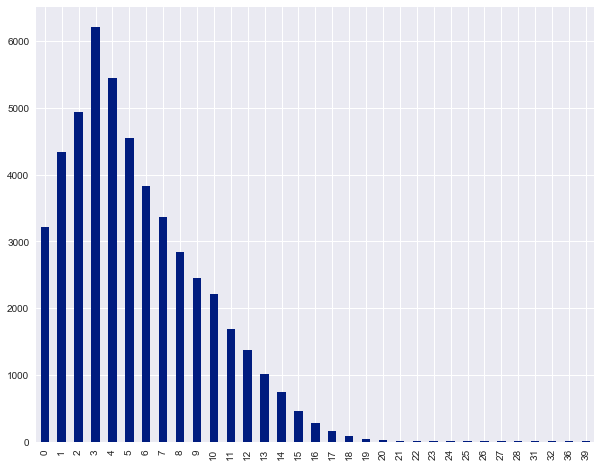

In [29]:
train_df.num_features.value_counts().sort_index().plot(kind='bar', figsize=(10,8))

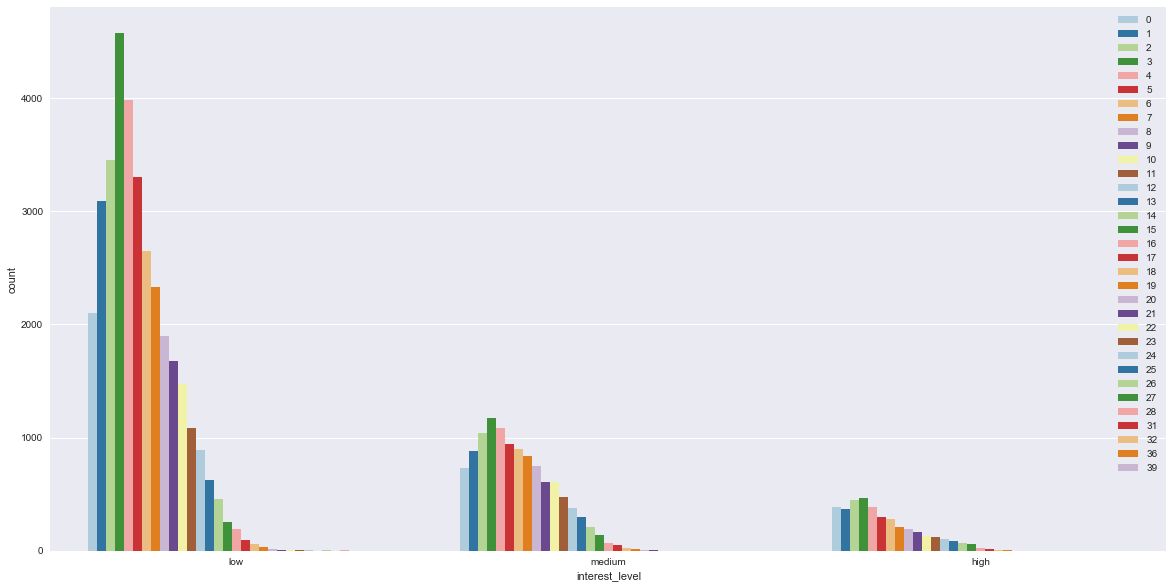

In [30]:
sns.countplot(x='interest_level', hue='num_features', data=train_df, order=[u'low', u'medium', u'high'], palette='Paired').legend(loc=1).figure.set_size_inches(20,10)

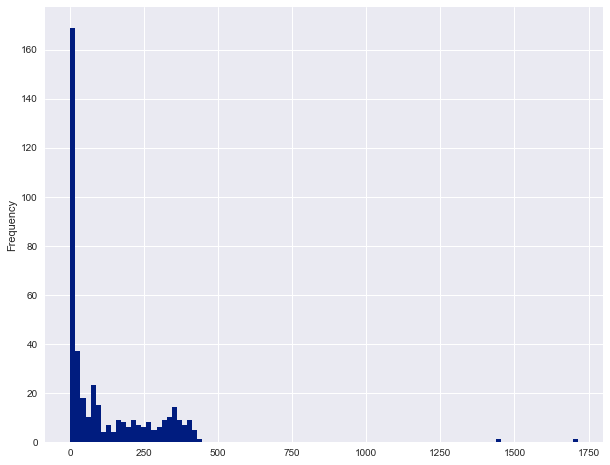

In [31]:
train_df.description_size.value_counts().sort_index().plot(kind='hist', bins=100, figsize=(10,8))

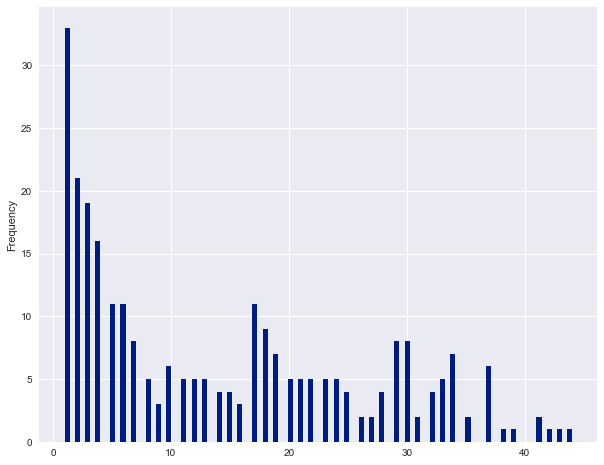

In [32]:
train_df[train_df.interest_level=='high'].description_size.value_counts().sort_index().plot(kind='hist', bins=100, figsize=(10,8))

In [33]:
train_df['month'] = train_df.created.dt.strftime('%b')
train_df['hod'] = train_df.created.dt.hour
train_df['dow'] = train_df.created.dt.strftime('%A')

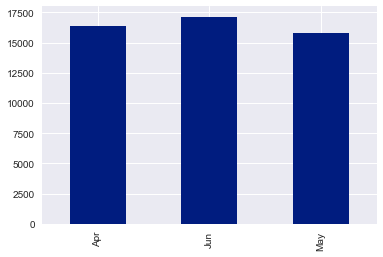

In [34]:
train_df.month.value_counts().sort_index().plot(kind='bar')

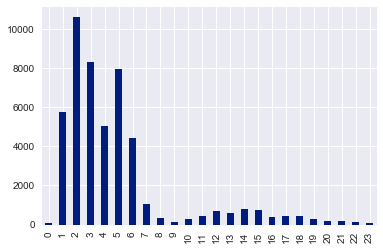

In [35]:
train_df.hod.value_counts().sort_index().plot(kind='bar')

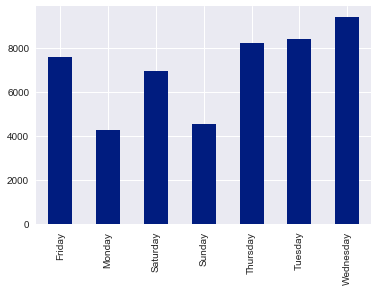

In [36]:
train_df.dow.value_counts().sort_index().plot(kind='bar')

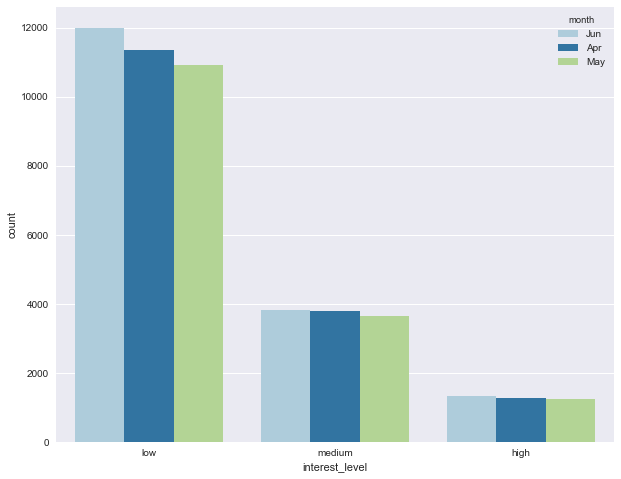

In [37]:
sns.countplot(x='interest_level', hue='month', data=train_df, order=[u'low', u'medium', u'high'], palette='Paired').figure.set_size_inches(10,8)

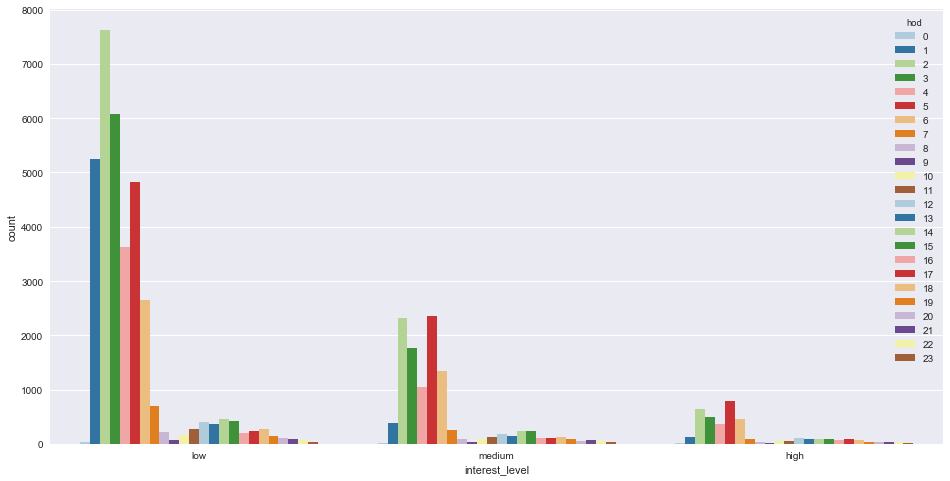

In [38]:
sns.countplot(x='interest_level', hue='hod', data=train_df, order=[u'low', u'medium', u'high'], palette='Paired').figure.set_size_inches(16,8)

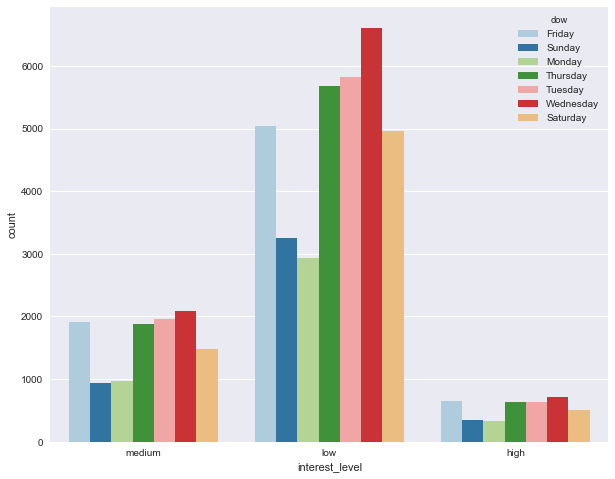

In [39]:
sns.countplot(x='interest_level', hue='dow', data=train_df, palette='Paired').figure.set_size_inches(10,8)

### Listings location

https://www.kaggle.com/shubh24/two-sigma-connect-rental-listing-inquiries/neighborhood-as-factor-reverse-geocoding - NOT ALLOWED in kaggle

In [40]:
# https://github.com/thampiman/reverse-geocoder
import reverse_geocoder as rg

In [41]:
train_coordinates = train_df[['listing_id', 'latitude', 'longitude']]

# Reverse Geocoder takes a list of tuples (of latitude and longitude) as its input.
lat_lon = []
listings = []

for i, j in train_coordinates.iterrows():
    lat_lon.append((j['latitude'], j['longitude']))
    listings.append(int(j['listing_id']))

In [42]:
results = rg.search(lat_lon)
# nbd = [[listings[i], results[i]['name']] for i in range(0, len(results))]

Loading formatted geocoded file...


In [43]:
for i in range(0, len(results)):
    train_df.loc[train_df['listing_id'] ==listings[i], 'neighborhood'] = results[i]['name']

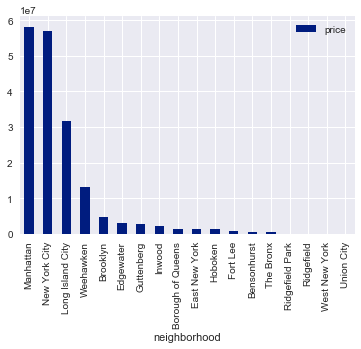

In [44]:
train_df.groupby('neighborhood').agg({'price':sum}).sort_values(by='price', ascending=False).plot(kind='bar')

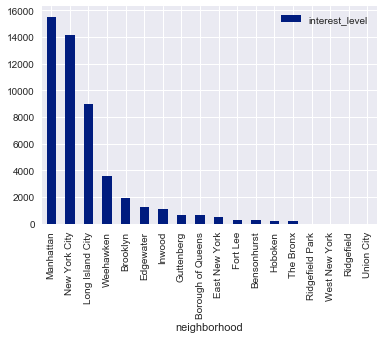

In [45]:
train_df.groupby('neighborhood').agg({'interest_level':'count'}).sort_values(by='interest_level', ascending=False).plot(kind='bar')

Instead of this let's use the clustering algorithm to create the neighborhoods ourselves.

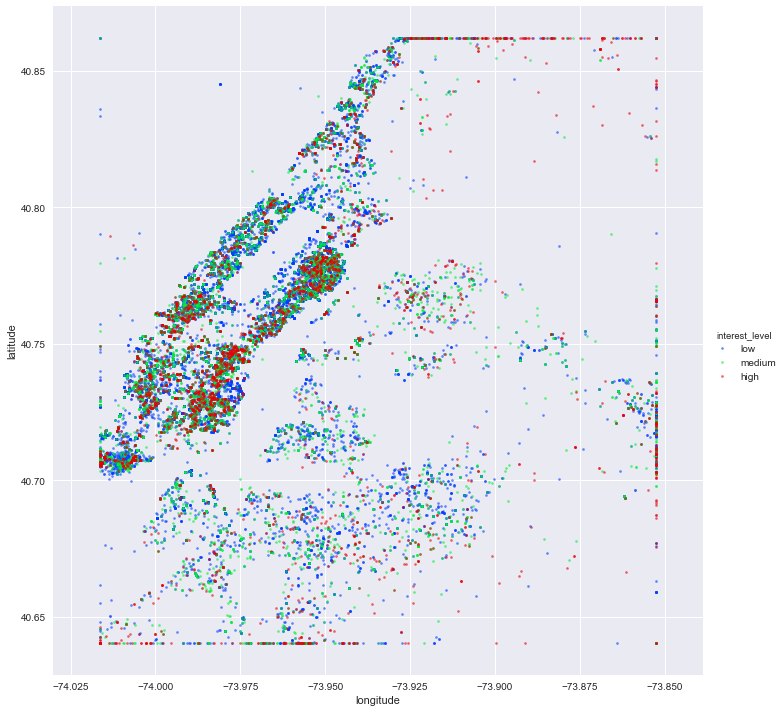

In [46]:
sns.lmplot(x='longitude', y='latitude', data=train_df, hue='interest_level', fit_reg=False, 
           scatter_kws={'alpha':0.6, 's':7}, size=10, hue_order=[u'low', u'medium', u'high'], palette='bright')

### Listings description

### Cleaning up character variables

In [47]:
train_df.display_address.value_counts()[:10]

Broadway             438
East 34th Street     355
Second Avenue        349
Wall Street          332
West 37th Street     287
West Street          258
First Avenue         244
Gold Street          241
Washington Street    237
York Avenue          228
Name: display_address, dtype: int64

In [48]:
train_df.street_address.value_counts()[:10]

3333 Broadway           174
505 West 37th Street    167
200 Water Street        160
90 Washington Street    142
100 Maiden Lane         131
401 East 34th Street    129
2 Gold Street           120
1 West Street           119
100 John Street         115
95 Wall Street          106
Name: street_address, dtype: int64

In [49]:
train_df[train_df.display_address.isin(train_df.street_address)==False][:3]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,street_address,price_log,listings_in_bldg,num_photos,num_features,description_size,month,hod,dow,neighborhood
0,2,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,41,7211212,...,792 Metropolitan Avenue,8,3,5,0,95,Jun,7,Friday,Long Island City
1,1,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,41,7150865,...,808 Columbus Avenue,9,24,11,5,9,Jun,12,Sunday,Manhattan
2,1,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,41,6887163,...,241 W 13 Street,8,58,8,4,94,Apr,3,Sunday,New York City


In [50]:
import unicodedata
import re

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii

In [51]:
train_df['display_address_ascii'] = [remove_accents(line) for line in train_df.display_address] 
train_df['street_address_ascii'] = [remove_accents(line) for line in train_df.street_address] 

In [52]:
pd.DataFrame(train_df['display_address_ascii'].unique()).to_csv('display_address_ascii.csv')
pd.DataFrame(train_df['street_address_ascii'].unique()).to_csv('street_address_ascii.csv')

In [53]:
def clean_addresses(df,column):
    return df['%s' % column].map(lambda x: ' '.join(x.strip('!@#$%^&*()-_+=;,./\\\'\t')\
                                                    .replace("'",'').lower()\
                                                    .replace(' street', ' st').replace(' avenue', ' ave')\
                                                    .replace(' road', ' rd').replace(' boulevard', ' blvd')\
                                                    .replace(' east', ' e').replace(' west', ' w')\
                                                    .replace('east ', 'e ').replace('west ', 'w ').split()))

In [54]:
train_df['display_address_clean'] = clean_addresses(train_df, 'display_address_ascii')
train_df.display_address_clean.value_counts()[:20]

wall st          451
broadway         443
e 34th st        441
w st             412
second ave       370
w 37th st        370
john st          346
gold st          345
york ave         316
washington st    304
w 42nd st        295
columbus ave     292
lexington ave    283
e 39th st        281
water st         280
first ave        268
e 79th st        253
e 35th st        251
w 54th st        240
e 89th st        238
Name: display_address_clean, dtype: int64

In [55]:
train_df['street_address_clean'] = clean_addresses(train_df, 'street_address_ascii')
train_df.street_address_clean.value_counts()[:20]

1 w st               216
200 water st         213
505 w 37th st        196
90 washington st     183
3333 broadway        175
401 e 34th st        164
100 john st          161
2 gold st            160
100 maiden lane      140
95 wall st           138
8 spruce st          130
95 christopher st    125
340 e 29th st        124
50 w 34th st         114
145 e 16th st        110
550 w 54th st        107
45 wall st           107
620 w 42nd st        106
116 john st          104
360 w 34th st        102
Name: street_address_clean, dtype: int64

In [56]:
df = train_df.where(train_df.display_address_clean.isin(train_df.street_address_clean) == False).dropna()
df[['display_address_clean', 'street_address_clean']]

,display_address_clean,street_address_clean
0,metropolitan ave,792 metropolitan ave
3,e 49th st,333 e 49th st
4,w 143rd st,500 w 143rd st
5,w 18th st,350 w 18th st
6,w 107th st,210 w 107th st
8,hamilton terrace,63 hamilton terrace
11,w. 173rd st,644 w. 173rd st
13,w 63rd st,30 w 63rd st
14,e 56th st,315 e 56th st
15,e 34th st,340 e 34th st


In [57]:
str1 = 'metropolitan ave'
str2 = '792 metropolitan ave'

str1 in str2

True

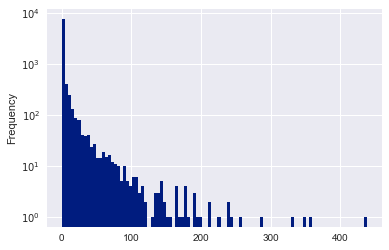

In [58]:
train_df.groupby('display_address')['display_address'].value_counts().plot(kind='hist', bins=100, log=True)

In [59]:
desc_count_vec = CountVectorizer(stop_words='english', max_features=200)
desc = desc_count_vec.fit_transform(train_df.description)
cols = desc_count_vec.get_feature_names()
desc_count_vec_df = pd.DataFrame(desc.todense(), columns=cols)
desc_count_vec_df.drop(['br'], axis=1, inplace=True)
desc_count_vec_df.head(3)

,24,_blank,access,amazing,amenities,amp,apartment,apartments,appliances,appointment,...,village,walk,washer,water,website_redacted,west,white,windows,wood,york
0,0,0,0,0,0,0,1,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,...,1,0,0,0,1,1,0,0,0,1


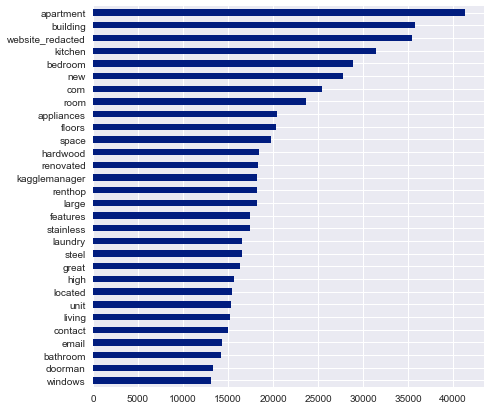

In [60]:
desc_counts = desc_count_vec_df.sum()
freq_words = desc_counts.nlargest(30).sort_values()
freq_words.plot(kind='barh', figsize=(7,7))

In [61]:
def plot_freq_words(df,column):
    desc_count_vec = CountVectorizer(stop_words='english', max_features=200)
    desc = desc_count_vec.fit_transform(df['%s' % column])
    cols = desc_count_vec.get_feature_names()
    desc_count_vec_df = pd.DataFrame(desc.todense(), columns=cols)
    desc_count_vec_df.drop(['br'], axis=1, inplace=True)
    desc_counts = desc_count_vec_df.sum()
    freq_words = desc_counts.nlargest(100).sort_values()
    freq_words.plot(kind='barh', figsize=(10,20))

In [62]:
train_df['description'][:10]

0    A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...
1                                                     
2    Top Top West Village location, beautiful Pre-w...
3    Building Amenities - Garage - Garden - fitness...
4    Beautifully renovated 3 bedroom flex 4 bedroom...
5                                                     
6    Stunning unit with a great location and lots o...
7    This huge sunny ,plenty of lights 1 bed/2 bath...
8                             <p><a  website_redacted 
9    This is a spacious four bedroom with every bed...
Name: description, dtype: object

In [63]:
train_df['description_clean'] = [remove_accents(line) for line in train_df.description] 

In [64]:
train_df['description_clean'] = [re.sub(r'[()?!@#$%^&*-;\'\"]', "", line).replace(","," ")\
                                 .replace("<br >", "").replace("<br />","").replace("<p>","").replace("</p>","")\
                                 .replace("<a  website_redacted", "")\
                                 .replace("apartment", "").replace("bedroom", "").replace("bathroom", "")
                                 .lower().strip() for line in train_df.description_clean]

In [65]:
train_df['description_clean'] = [re.sub(re.compile(r'\s+'), " ", line) for line in train_df.description_clean]

In [66]:
def do_lem(str):
    return " ".join([WordNetLemmatizer().lemmatize(word) for word in str.split(" ")])

def do_stem(str):
    return " ".join([PorterStemmer().stem(word) for word in str.split(" ")])

In [67]:
do_lem("Look no further!!!  This giant 2 bedroom apartment is located in the most sought-after of Inwood Manhattan.  For about the same price of a tiny studio in the village,  you get this super massive apartment, sun-bathed, in an amazingly clean, elevator building.Equipped with brand new, stainless steel appliances, granite counter-tops, renovated bathroom, hardwood floors,  sunken living room, a ton of closet space,  king sized living rooms, high ceilings,  LIVE LIKE A KING!   A very functional, and spacious layout, close to Subway, just 30 minutes from midtown, Manhattan on the A line.<br /><br />Do not hesitate,  call HANS right now at 589-104-6401 today! <br /><br /><br /><br /><br /><br />Bond New York is a real estate broker that supports equal housing opportunity.<p><a  website_redacted")

u'Look no further!!!  This giant 2 bedroom apartment is located in the most sought-after of Inwood Manhattan.  For about the same price of a tiny studio in the village,  you get this super massive apartment, sun-bathed, in an amazingly clean, elevator building.Equipped with brand new, stainless steel appliances, granite counter-tops, renovated bathroom, hardwood floors,  sunken living room, a ton of closet space,  king sized living rooms, high ceilings,  LIVE LIKE A KING!   A very functional, and spacious layout, close to Subway, just 30 minute from midtown, Manhattan on the A line.<br /><br />Do not hesitate,  call HANS right now at 589-104-6401 today! <br /><br /><br /><br /><br /><br />Bond New York is a real estate broker that support equal housing opportunity.<p><a  website_redacted'

In [68]:
try:
    train_df['description_clean'] = [do_lem(line) for line in train_df.description_clean]
except:
    print line

In [69]:
#train_df['description_clean'] = [do_stem(line) for line in train_df.description_clean] #do not like the top

In [70]:
train_df.description_clean[:10]

0    a brand new bedroom bath apartmentenjoy these ...
1                                                     
2    top top west village location beautiful prewar...
3    building amenity garage garden fitness room la...
4    beautifully renovated flex for rent available ...
5                                                     
6    stunning unit with a great location and lot of...
7    this huge sunny plenty of light bed bath offer...
8                                                     
9    this is a spacious four with every able to fit...
Name: description_clean, dtype: object

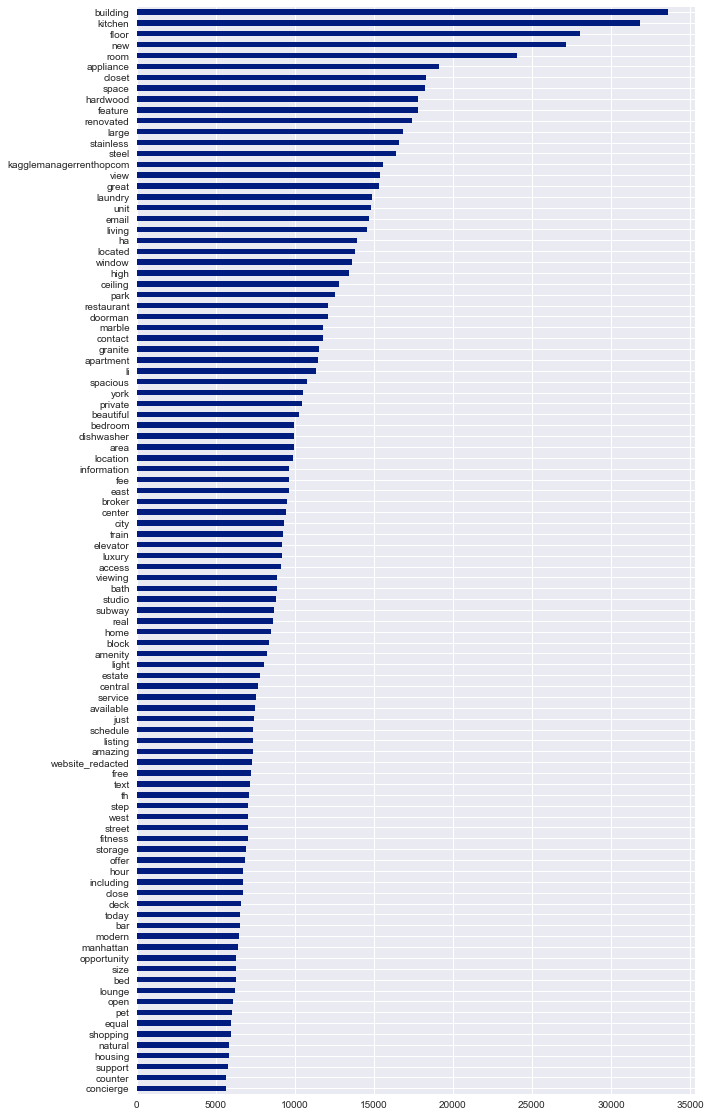

In [71]:
plot_freq_words(train_df, 'description_clean')

In [ ]:
from nltk.corpus import stopwords
import string
 
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['<br >', '<br />', '<p>', '</p>','<a  website_redacted']

In [ ]:
train_df['description_clean_v2'] = " ". join([word for word in line.split() for line in train_df.description if word not in stop])

In [72]:
description_example = """Look no further!!!  This giant 2 bedroom apartment is located in the most sought-after 
    of Inwood Manhattan.  For about the same price of a tiny studio in the village,  you get this super massive 
    apartment, sun-bathed, in an amazingly clean, elevator building.Equipped with brand new, stainless steel 
    appliances, granite counter-tops, renovated bathroom, hardwood floors,  sunken living room, a ton of closet 
    space,  king sized living rooms, high ceilings,  LIVE LIKE A KING!   A very functional, and spacious layout, 
    close to Subway, just 30 minute from midtown, Manhattan on the A line.<br /><br />Do not hesitate,  
    call HANS right now at 589-104-6401 today! <br /><br /><br /><br /><br /><br />Bond New York is a real estate 
    broker that support equal housing opportunity.<p><a  website_redacted"""

In [74]:
tokens = nltk.word_tokenize(description_example)

In [75]:
#Create your bigrams
#bgs = nltk.bigrams(tokens) 
bgs = nltk.ngrams(tokens,3) 

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
for k,v in fdist.items():
    print k,v

('a', 'ton', 'of') 1
('Manhattan', 'on', 'the') 1
('opportunity.', '<', 'p') 1
('bathroom', ',', 'hardwood') 1
('in', 'the', 'village') 1
('call', 'HANS', 'right') 1
('589-104-6401', 'today', '!') 1
('tiny', 'studio', 'in') 1
('p', '>', '<') 1
('>', '<', 'br') 6
('get', 'this', 'super') 1
('with', 'brand', 'new') 1
(',', 'just', '30') 1
('/', '>', 'Do') 1
('not', 'hesitate', ',') 1
('30', 'minute', 'from') 1
('room', ',', 'a') 1
('a', 'real', 'estate') 1
('most', 'sought-after', 'of') 1
('very', 'functional', ',') 1
('A', 'very', 'functional') 1
('same', 'price', 'of') 1
('This', 'giant', '2') 1
('bedroom', 'apartment', 'is') 1
('this', 'super', 'massive') 1
('/', '>', 'Bond') 1
('elevator', 'building.Equipped', 'with') 1
('Look', 'no', 'further') 1
('sized', 'living', 'rooms') 1
('real', 'estate', 'broker') 1
('appliances', ',', 'granite') 1
('A', 'line.', '<') 1
('!', 'A', 'very') 1
('ton', 'of', 'closet') 1
('>', 'Do', 'not') 1
(',', 'sunken', 'living') 1
('minute', 'from', 'midtown

In [86]:
from nltk.collocations import *
tokens = description_example.split(" ")

bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(3)
print finder.nbest(bigram_measures.pmi, 100)
print finder.ngram_fd.viewitems()

[('/><br', '/><br'), ('\n', ''), ('', '')]
dict_items([(('\n', ''), 7), (('/><br', '/><br'), 4), (('', ''), 15)])


In [87]:
len(finder.ngram_fd)

3

In [91]:
finder.ngram_fd.keys()

[('\n', ''), ('/><br', '/><br'), ('', '')]

In [93]:
print "%s %s" % (finder.ngram_fd.keys()[1][0], finder.ngram_fd.keys()[1][0])

/><br /><br


In [94]:
def get_freq_bigram(str):
    adict = {}
    tokens = str.split()
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(3)
    if len(finder.ngram_fd) > 0:
        key = '%s %s' % (finder.ngram_fd.keys()[0][0], finder.ngram_fd.keys()[0][1])
        adict[key] = finder.ngram_fd.values()
    else: 
        adict["no_bigrams"] = 0
    return adict

In [96]:
train_df['description_freq_bigrams'] = [get_freq_bigram(line) for line in train_df.description_clean]

In [97]:
train_df.description_freq_bigrams[:10]

0    {u'no_bigrams': 0}
1    {u'no_bigrams': 0}
2    {u'no_bigrams': 0}
3    {u'no_bigrams': 0}
4    {u'no_bigrams': 0}
5    {u'no_bigrams': 0}
6    {u'no_bigrams': 0}
7      {u'to the': [3]}
8    {u'no_bigrams': 0}
9    {u'no_bigrams': 0}
Name: description_freq_bigrams, dtype: object

In [ ]:
description_corpus = " ". join([line for line in train_df.description])

In [ ]:
description_corpus[10:]

In [ ]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

token = nltk.word_tokenize(description_corpus)
bigrams = ngrams(token,2)
trigrams = ngrams(token,3)
fourgrams = ngrams(token,4)
fivegrams = ngrams(token,5)

print Counter(bigrams).most_common(3)

In [101]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(train_df['description_clean'])

In [102]:
x.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [103]:
v.vocabulary_

{u'stovecable': 50094,
 u'viewscity': 56766,
 u'maintenancelow': 33269,
 u'trainsjust': 54329,
 u'prewarbuilt': 40995,
 u'rentalcontact': 42827,
 u'balconyhigh': 5279,
 u'homewhile': 26641,
 u'villagebldg': 57060,
 u'superwill': 51658,
 u'roomtennis': 44614,
 u'hanging': 25616,
 u'woody': 59207,
 u'balconny': 5222,
 u'sation': 45077,
 u'moresuper': 35476,
 u'marblelaundry': 33656,
 u'offerthese': 37482,
 u'conveterible': 13820,
 u'chatter': 11413,
 u'yourselfswn': 59845,
 u'floorsmicrowavedishwashercentral': 22606,
 u'cycling': 14903,
 u'officedressing': 37524,
 u'cherryshaker': 11545,
 u'laundrydownstairs': 30292,
 u'wsouthern': 59382,
 u'viewkagglemanagerrenthopcom': 56659,
 u'tryoncloisters': 54868,
 u'kitchenclosetsgreat': 29423,
 u'threetwobath': 53010,
 u'otherslocated': 38302,
 u'ceilingsgenerous': 10624,
 u'lightwithin': 31497,
 u'charmhigh': 11393,
 u'furnishingsbedroom': 23916,
 u'cornercall': 13982,
 u'cleaneryes': 12063,
 u'wince': 58683,
 u'locationhour': 32339,
 u'superan

In [104]:
from collections import OrderedDict

d = v.vocabulary_
d_ascending = OrderedDict(sorted(d.items(), key=lambda kv: kv[1]))
d_descending = OrderedDict(sorted(d.items(), 
                                  key=lambda kv: kv[1], reverse=True))

In [105]:
d_descending

OrderedDict([(u'zzzzzz', 60027),
             (u'zwirner', 60026),
             (u'zwerling', 60025),
             (u'zweben', 60024),
             (u'zurilee', 60023),
             (u'zur', 60022),
             (u'zumiez', 60021),
             (u'zumba', 60020),
             (u'zuma', 60019),
             (u'zum', 60018),
             (u'zucker', 60017),
             (u'zucchetti', 60016),
             (u'zubzero', 60015),
             (u'ztrain', 60014),
             (u'zto', 60013),
             (u'zsolt', 60012),
             (u'zr', 60011),
             (u'zplease', 60010),
             (u'zou', 60009),
             (u'zoociti', 60008),
             (u'zoo', 60007),
             (u'zoning', 60006),
             (u'zonexlarge', 60005),
             (u'zonethis', 60004),
             (u'zonesthis', 60003),
             (u'zonesone', 60002),
             (u'zonepet', 60001),
             (u'zonehuge', 60000),
             (u'zonefully', 59999),
             (u'zoned', 59998),
       

In [106]:
train_df.features.head(10)

0                                                   []
1    [Doorman, Elevator, Fitness Center, Cats Allow...
2    [Laundry In Building, Dishwasher, Hardwood Flo...
3                            [Hardwood Floors, No Fee]
4                                            [Pre-War]
5                                                   []
6    [prewar, elevator, Dogs Allowed, Cats Allowed,...
7    [Doorman, Elevator, Pre-War, Terrace, Laundry ...
8    [Cats Allowed, Dogs Allowed, Elevator, Laundry...
9                        [Dishwasher, Hardwood Floors]
Name: features, dtype: object

In [107]:
def clean_features(alist):
    if len(alist) == 0:
        return alist
    return [x.lower().strip('!@#$%^&*()-_+=;,./\\\'\t').replace(' ', '').replace('-','') for x in alist]

In [108]:
train_df['features_clean'] = train_df.features.apply(lambda alist: clean_features(alist))
train_df.features_clean.head(10)

0                                                   []
1    [doorman, elevator, fitnesscenter, catsallowed...
2    [laundryinbuilding, dishwasher, hardwoodfloors...
3                              [hardwoodfloors, nofee]
4                                             [prewar]
5                                                   []
6    [prewar, elevator, dogsallowed, catsallowed, l...
7    [doorman, elevator, prewar, terrace, laundryin...
8    [catsallowed, dogsallowed, elevator, laundryin...
9                         [dishwasher, hardwoodfloors]
Name: features_clean, dtype: object

In [109]:
train_df['combined_features'] = train_df.features_clean.apply(lambda l: ', '.join(l))
feature_count_vec = CountVectorizer(stop_words='english', max_features=200)
features = feature_count_vec.fit_transform(train_df.combined_features)
cols = feature_count_vec.get_feature_names()
feature_count_vec_df = pd.DataFrame(features.todense(), columns=cols)
feature_count_vec_df.head()

,24,24hrdoorman,2blkstobedfordlstop,7concierge,7doorman,actualapt,airconditioning,allmodern,allutilitiesincluded,assignedparkingspace,...,virtualdoorman,walkincloset,wallsofwindows,washer,washerinunit,wheelchairaccess,wheelchairramp,wifiaccess,woodburningfireplace,work
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


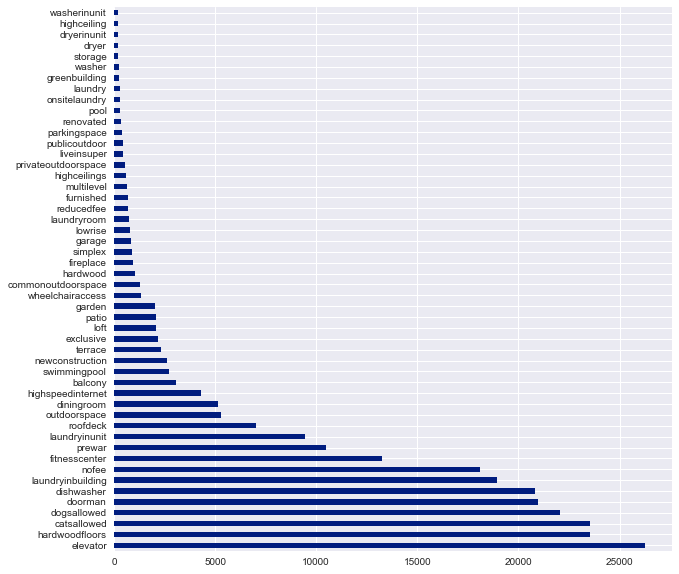

In [110]:
feature_counts = feature_count_vec_df.sum()
freq_feature_words = feature_counts.nlargest(50)
freq_feature_words.plot(kind='barh', figsize=(10,10))

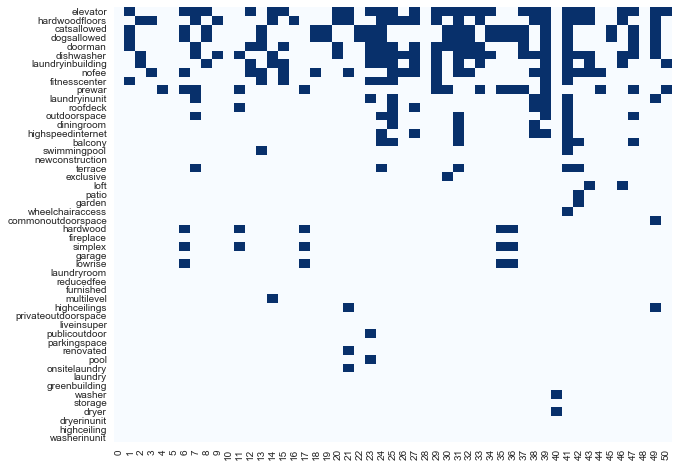

In [111]:
plt.figure(figsize=(10, 8))
sns.heatmap(feature_count_vec_df.loc[:50, freq_feature_words.index].T, cmap='Blues', cbar=False)

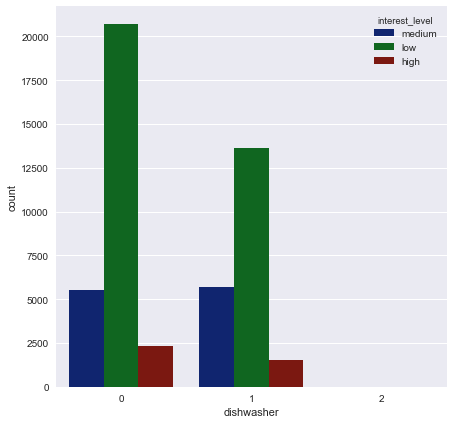

In [112]:
plt.figure(figsize=(7, 7))
sns.countplot(feature_count_vec_df.dishwasher, hue=train_df.interest_level)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13e191350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x6dc772490>]], dtype=object)

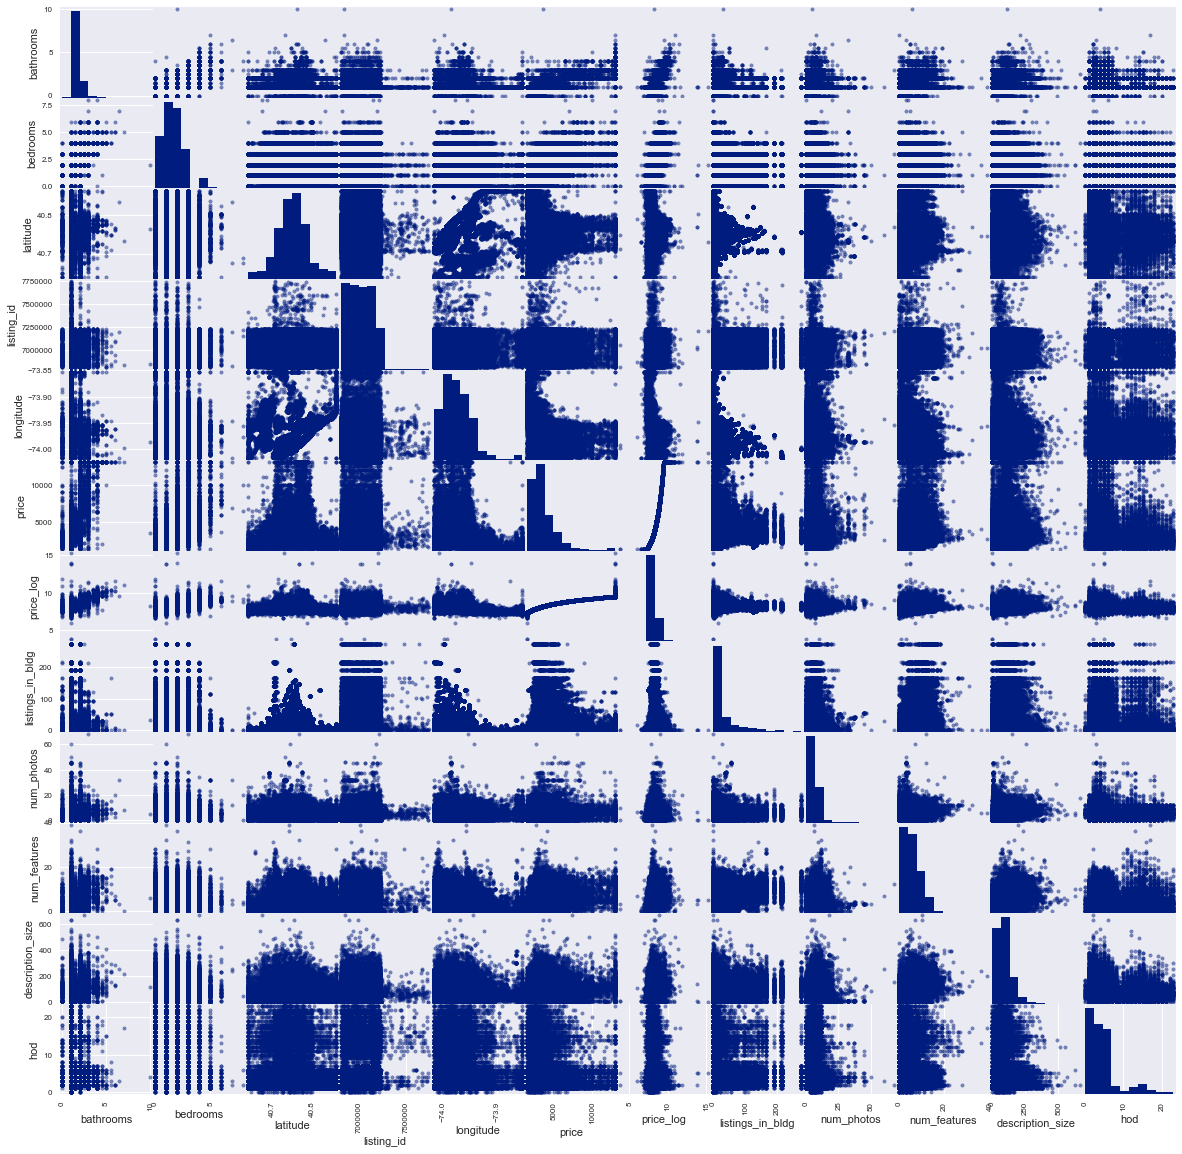

In [113]:
# Scatter Matrix
pd.scatter_matrix(train_df, figsize=(20, 20))

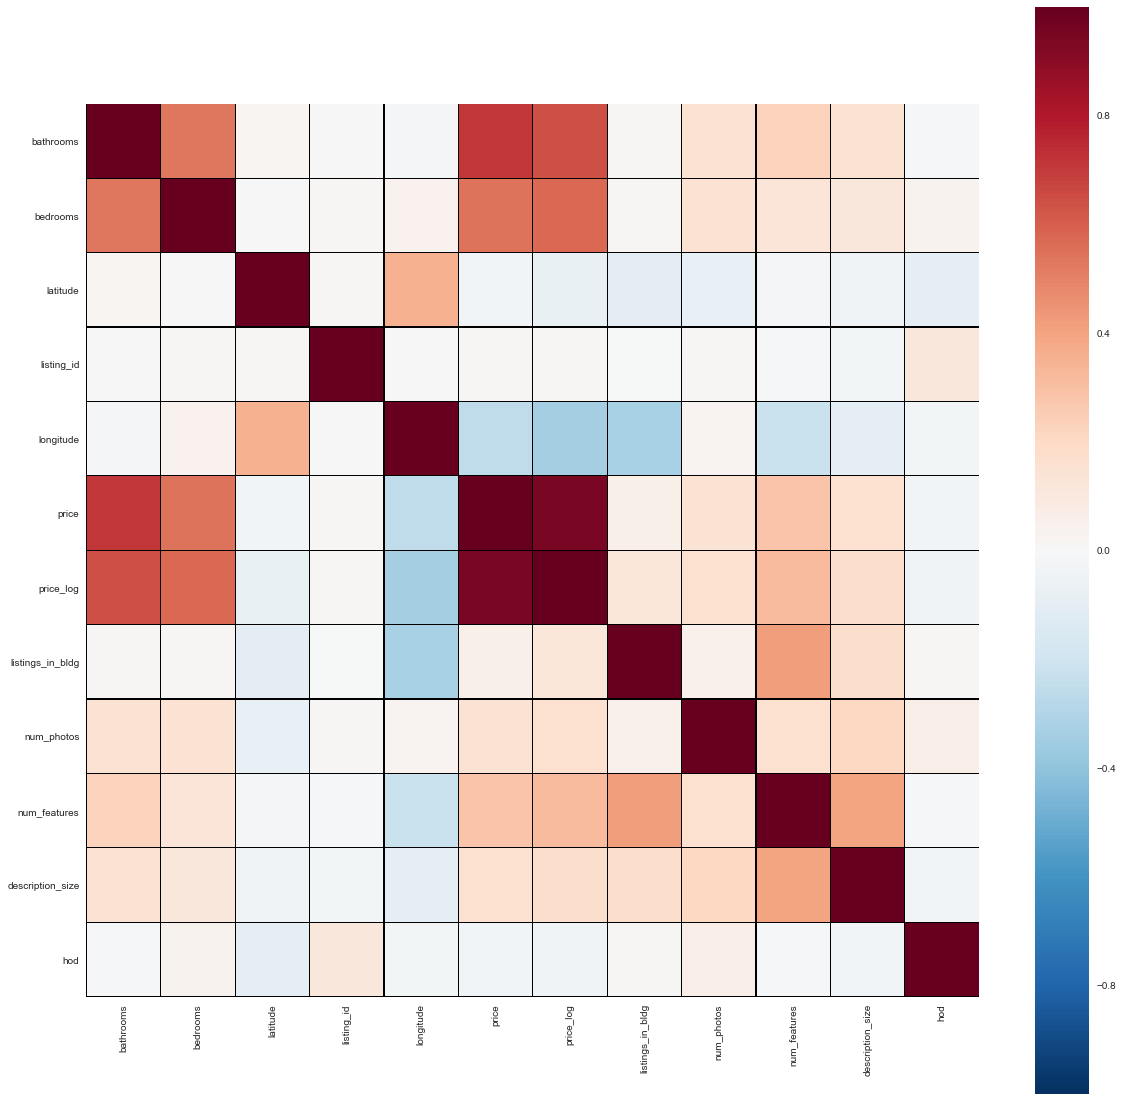

In [114]:
# Pearson Correlation Matrix
sns.heatmap(train_df.corr(), linewidths=0.25, vmax=1.0, square=True , linecolor='black').figure.set_size_inches(20,20)